# Analysis of Rana Models (Model 3)
Only model 3 of the original notebook is included here since model 1 is essentailly the model by dos Santos, et. al., and model 2 is a subset of model 3 for appropriate parameters.

Run the cell below to initialize things ***only once***. Otherwise there's a *good* chance you will overwrite `PROJECT_ROOT_DIR`, which is really not too good indeed. (The 4 cells below are marked as "initialization cells", which is an extension provided in `Jupyter-contrib nbextensions`.)

In [1]:
import os
PROJECT_ROOT_DIR = os.getcwd()

import numpy as np
import scipy.misc as smp
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import cv2
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor

from IPython import display
from IPython.display import clear_output

print('Project is located at', PROJECT_ROOT_DIR)

MODEL_ROOT_DIR = os.path.join(PROJECT_ROOT_DIR, 'model3')
os.chdir(MODEL_ROOT_DIR)
print('Now working in', os.getcwd())

Project is located at /Volumes/Samsung_T5/spring2020ml-predictingvirusbodyload/Milestone1/Rana Model
Now working in /Volumes/Samsung_T5/spring2020ml-predictingvirusbodyload/Milestone1/Rana Model/model3


In [2]:
# Just a visualization tool...
def update_progress(progress, name='Progress'):
    # Progress bar from https://www.mikulskibartosz.name/how-to-display-a-progress-bar-in-jupyter-notebook/
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait=True)
    text = "{2}: [{0}] {1:.1f}%".format(
        "#" * block + "-" * (bar_length - block), progress * 100, name)
    print(text)

## Generate Simulation Data
Here we analyze the third model presented in Rana et. al. The simulation from the given notebook is adapted to `model3.py`, with unnecessary components removed. The script also saves all intermediate frames in a structured directory format with relevant parameters logged for future references.

In [3]:
import model3

In [4]:
# Numerically encoded cell states
CELL_H = 0 # Healthy
CELL_Ht1 = 2  # Therapy 1
CELL_Ht2 = 8  # Therapy 2
CELL_HtB = 10  # Dual Therapy
CELL_D = 16 # Dead
CELL_A1 = 4 # Acute Infected
CELL_A2 = 1 # Latent Infected

# Self-defined color map for consistent coloring.
mycmap = {
    CELL_H: [0, 255, 0],
    CELL_D: [0, 0, 0],
    CELL_A1: [255, 0, 0],
    CELL_A2: [255, 255, 0],
    CELL_Ht1: [148, 0, 211],
    CELL_Ht2: [75, 0, 130],
    CELL_HtB: [0, 0, 255]
}

# Used for legends and stuff.
names = {
    CELL_H: 'Healthy', 
    CELL_Ht1: 'Healthy w/ Treatment 1',
    CELL_Ht2: 'Healthy w/ Treatment 2',
    CELL_HtB: 'Healthy w/ Both Treatments',
    CELL_D: 'Dead', 
    CELL_A1: 'Acute Infected', 
    CELL_A2: 'Latent Infected'
}

### Choose Simulation Parameters
This can be *very* computationally heavy. The simulation will call ext

In [4]:
from itertools import product

L_LIST = [1000]
P_HIV_LIST = [0.04, 0.05, 0.06]
P_REPH_LIST = [0.99, 0.98, 0.97]
P_REPI_LIST = [1e-5, 2e-5]
TAU_LIST = [4, 5, 6]
P_ADH_LIST = [0.9]
REPLICATIONS_LIST = [25]
allParams = list(product(L_LIST, P_HIV_LIST, P_REPH_LIST, P_REPI_LIST,
                         TAU_LIST, P_ADH_LIST, REPLICATIONS_LIST))

In [7]:
for param in allParams:
    L, P_HIV, P_repH, P_repI, tau, P_adh, replications = param
    model3.run(L=L, P_HIV=P_HIV, P_repH=P_repH, P_repI=P_repI,
               tau=tau, P_adh=P_adh, replications=replications)

Progress: [####################] 100.0%
Simulation results saved under the directory "03-22-2020 09.29.05".


### Plotting Simulation Output
Here we just plot some simulation results to see if they look like what we'd expect.

In [101]:
FOLDER_NAME = '03-22-2020 09.29.05'
os.chdir(FOLDER_NAME)

In [105]:
def plotFrame(run, t):
    picture = np.load(str(run) + '/' + str(t) + '.npy')
    # Create a 100x100x3 array of 8 bit unsigned integers
    data = np.zeros((1000,1000,3), dtype=np.uint8)
    # Convert picture array to image
    for row in range(0, len(data)):
        for col in range(0, len(data)):
            data[row][col] = mycmap[picture[row][col]]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = plt.imshow(data)
    
    colors = {k:im.cmap(im.norm(k)) for k in names.keys()}
    # create a patch (proxy artist) for every color 
    patches = [mpatches.Patch(color=list(map(lambda x : x / 255, mycmap[k])), label=names[k]) for k in names.keys()]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1, 1), loc=2, borderaxespad=0. )
    
    # plt.show()
    plt.savefig('test.png', dpi=600)

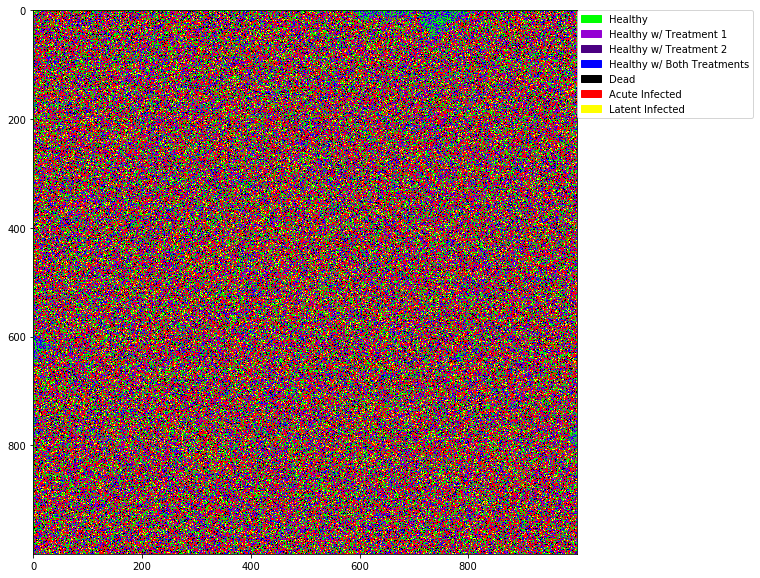

In [106]:
plotFrame(1, 300)

## Image Processing
Here we use image processing algorithms from `OpenCV` to extract image features from the simulation result obtained earlier in the notebook.

### Helper Functions and Features to Extract
First we define a few helper functions that will be used in processing the image. `gridToOpenCVImage` converts a simulation grid fresh off of the CPU to an image operable by the `OpenCV` library.

In [19]:
# Helper function that converts a raw simulation result into an image operable
# by the OpenCV library.
def gridToOpenCVImage(grid):
    # Create a L by L by 3 np array
    res = np.zeros([*grid.shape, 3], dtype=np.uint8)
    
    # Note that openCV stores image in BGR format. The colors
    # in mycmap are given in RGB.
    for row in range(len(grid)):
        for col in range(len(grid[0])):
            # Gets the color in mycmap and reverse it to BGR
            res[row][col] = mycmap[grid[row][col]][::-1]
    
    return res

Next we define two helper functions that will help us compute the desired statistics once we have all the keypoints corresponding to all the wanted blobs in the image.

In [20]:
def getAvgDistance(keypoints):
    if keypoints == []:
        return 0
    
    N = len(keypoints)
    res = 0
    
    for kpi in keypoints:
        for kpj in keypoints:
            x1, y1 = kpi.pt
            x2, y2 = kpj.pt
            res += np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
    
    return res / (2 * N)

In [21]:
def getAvgSize(keypoints):
    if keypoints == []:
        return 0
    
    return np.average([kp.size for kp in keypoints])

For each image, we extract the number of blobs with a minimum area of 5, and the average distance and average size of those keypoints, and also the same statistics for blobs with a minimum area of 2. In total, each image is summarized by these 6 features.

In [22]:
# Helper function to run the SimpleBlobDetector algorithm on a given image.
# Return all found blobs with minimum area selected by input.
def getKeypoints(im, area):
    params = cv2.SimpleBlobDetector_Params()
    
    params.minThreshold = 1
    params.maxThreshold = 200
    
    params.filterByArea = True
    params.minArea = area

    params.filterByCircularity = False
    params.filterByConvexity = False
    params.filterByInertia = False
    
    detector = cv2.SimpleBlobDetector_create(params)
    return detector.detect(im)

In [23]:
# Returns all the 6 features from each image. The format of return is a 1x6
# numpy array with fields [num, dist, avg size, num, dist, avg size] where
# the first 3 correspond to keypoints obtained when minArea = 5
def getFeatures(im):
    keypoints_5 = getKeypoints(im, 5)
    keypoints_2 = getKeypoints(im, 2)
    
    return np.array([
        len(keypoints_5), getAvgDistance(keypoints_5), getAvgSize(keypoints_5),
        len(keypoints_2), getAvgDistance(keypoints_2), getAvgSize(keypoints_2),
    ])

### Generating Feature Data
We walk through all the simulation data and extract features on the $t=0$ grid of each run of the simulation. We also build the spreadsheet that will be used by the machine learning algorithm later.

In [24]:
def getSubDirs():
    return [os.path.join(os.getcwd(), d) for d in os.listdir() 
            if os.path.isdir(os.path.join(os.getcwd(), d)) 
            and not d == '__pycache__']

We crawl through all the simulation results under the directory and build a spreadsheet with all the features and the prevelance count of all cells for each run of every simulation. This is time-consuming, so we will save the spreadsheet instead of computing all the features every time.

In [25]:
# Helper method to run get the spread sheet for each simulation.
def getSimDataFrame(sim_dir):
    # Enter the directory containing all the replications of one simulation
    # All runs under this directory have the same parameters, but are repeated
    # for the sake of reducing standard error.
    os.chdir(sim_dir)
    
    # Read in the prevelance of states csv
    prevelance_df = pd.read_csv('prevelance.csv')
    # Create a blank dataframe to fill in values later
    feature_df = pd.DataFrame(np.zeros([len(getSubDirs()), 6]), 
                              columns=['5_num', '5_avg_dist', '5_avg_size', 
                                       '2_num', '2_avg_dist', '2_avg_size'])
    
    # For each run, load the t=0 np array and extract all features
    for run_dir, run in zip(getSubDirs(), range(len(getSubDirs()))):
        os.chdir(run_dir)
        
        im = gridToOpenCVImage(np.load('0.npy'))
        feature_df.iloc[run] = getFeatures(im)
    
    # Join the prevelance_df and feature_df on index.
    return pd.merge(feature_df, prevelance_df, left_index=True, right_index=True)

In theory, the cell below will do the trick - it will crawl through all directories and construct a dataframe from all the stored data. But it is *so damn slow*, so instead of executing the task in the jupyter notebook environment, I copied all the data to `proc.py`, where some code are modified so that this task can be run in parallel. (Jupyter notebook doesn't work well with `ProcessPoolExecutor`.) Specifically, in the function above, the code of reading the `0.npy` file of every run and extracting features from the file is converted to run in parallel.

In [ ]:
os.chdir(MODEL_ROOT_DIR)

L = len(getSubDirs())
dfs = []

# Crawl through all the simulation directories and record the spreadsheet
# Merge them at the end.
for sim_dir, sim_dir_count in zip(getSubDirs(), range(L)):
    dframe = getSimDataFrame(sim_dir)
    dfs.append(dframe)
    print(sim_dir_count + 1, 'out of', L, 'done.')

print('Combining DataFrames')
df = pd.concat(dfs)
df = df.reset_index().drop('index', axis=1)

print('Saving Result')
os.chdir(MODEL_ROOT_DIR)
df.to_csv('data.csv')

## Machine Learning
We use the spreadsheet generated from the cells below (or, rather, `proc.py`) as inputs to our machine learning algorithm.

In [7]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

from IPython.display import SVG, display
from graphviz import Source
from sklearn.tree import export_graphviz

os.chdir(MODEL_ROOT_DIR)

In [8]:
df = pd.read_csv('data.csv', index_col='Unnamed: 0')
df.head(5)

5_num    5_avg_dist  5_avg_size  10_num  10_avg_dist  10_avg_size  \
0  317.0  84353.944650    2.977280     0.0     0.000000     0.000000   
1  337.0  88484.903684    2.985519     2.0   330.590336     4.044532   
2  288.0  74366.384917    2.979618     0.0     0.000000     0.000000   
3  299.0  77935.545271    2.960476     0.0     0.000000     0.000000   
4  311.0  79682.343783    2.964499     1.0     0.000000     4.098555   

          H      H_T1     H_T2      H_Tb        A1       A2        D  
0  262522.0  166134.0  73504.0  158115.0  226086.0  56536.0  57103.0  
1  262539.0  166461.0  73741.0  157878.0  225737.0  56467.0  57177.0  
2  263528.0  166334.0  73582.0  158339.0  224656.0  56565.0  56996.0  
3  262722.0  165350.0  73594.0  157982.0  226877.0  56612.0  56863.0  
4  263257.0  165257.0  73706.0  158576.0  225707.0  56548.0  56949.0

In [9]:
# These are the features of our dataset
X_cols = ['5_num', '5_avg_dist', '5_avg_size', '10_num', '10_avg_dist', '10_avg_size']
y_cols = ['H', 'H_T1', 'H_T2', 'H_Tb', 'A1', 'A2', 'D']

As of right now, the features of our data are given in raw cell counts. We convert these to ratios, keeping in mind that each simulation is a $1000\times 1000$ grid, so there are $1\times 10^6$ cells in total.

In [10]:
for col in y_cols:
    df[col] = df[col].map(lambda x : x / 1e6)
df.head(5)

5_num    5_avg_dist  5_avg_size  10_num  10_avg_dist  10_avg_size  \
0  317.0  84353.944650    2.977280     0.0     0.000000     0.000000   
1  337.0  88484.903684    2.985519     2.0   330.590336     4.044532   
2  288.0  74366.384917    2.979618     0.0     0.000000     0.000000   
3  299.0  77935.545271    2.960476     0.0     0.000000     0.000000   
4  311.0  79682.343783    2.964499     1.0     0.000000     4.098555   

          H      H_T1      H_T2      H_Tb        A1        A2         D  
0  0.262522  0.166134  0.073504  0.158115  0.226086  0.056536  0.057103  
1  0.262539  0.166461  0.073741  0.157878  0.225737  0.056467  0.057177  
2  0.263528  0.166334  0.073582  0.158339  0.224656  0.056565  0.056996  
3  0.262722  0.165350  0.073594  0.157982  0.226877  0.056612  0.056863  
4  0.263257  0.165257  0.073706  0.158576  0.225707  0.056548  0.056949

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df[X_cols], df[y_cols])

clf = DecisionTreeRegressor()
clf.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

We check how good our predictions are.

In [12]:
predictions = clf.predict(X_test)
print('The RMSE of our tree on each column is')
print(np.sqrt(np.mean((predictions - y_test) ** 2)))

The RMSE of our tree on each column is
H       0.023681
H_T1    0.015816
H_T2    0.006834
H_Tb    0.014638
A1      0.061944
A2      0.001017
D       0.001171
dtype: float64


We visualize the tree below.

In [17]:
def plot_tree(clf, labels, target):
    graph = Source(export_graphviz(clf, 
        out_file=None, feature_names=labels, class_names=target, filled=True))
    display(SVG(graph.pipe(format='svg')))

In [18]:
plot_tree(clf, X_cols, y_cols)